In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
import scipy.sparse

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import datetime
import random
import traceback

import collections
import re
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
PAD_TOKEN = '__PAD__'
TOKEN_RE = re.compile(r'[\w\d]+')

In [ ]:
def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]

def tokenize_corpus(text, tokenizer=tokenize_text_simple_regex):
    return [tokenizer(sentence) for sentence in text]

In [ ]:
def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq

In [ ]:
def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=True):
    assert mode in {'tfidf', 'idf', 'tf', 'bin'}

    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    # получаем бинарные вектора "встречается или нет"
    if mode == 'bin':
        result = (result > 0).astype('float32')

    # получаем вектора относительных частот слова в документе
    elif mode == 'tf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))

    # полностью убираем информацию о количестве употреблений слова в данном документе,
    # но оставляем информацию о частотности слова в корпусе в целом
    elif mode == 'idf':
        result = (result > 0).astype('float32').multiply(1 / word2freq)

    # учитываем всю информацию, которая у нас есть:
    # частоту слова в документе и частоту слова в корпусе
    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(1 / word2freq)  # разделить каждый столбец на вес слова

    if scale:
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()

In [ ]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


In [ ]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


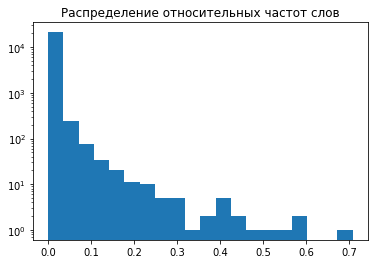

In [ ]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [ ]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


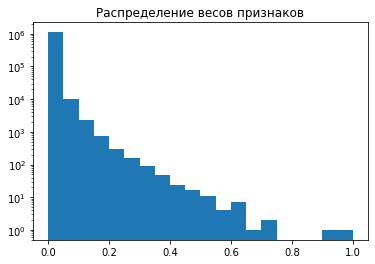

In [ ]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

In [ ]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


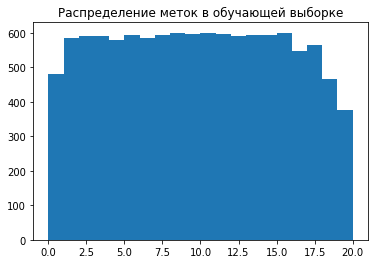

In [ ]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

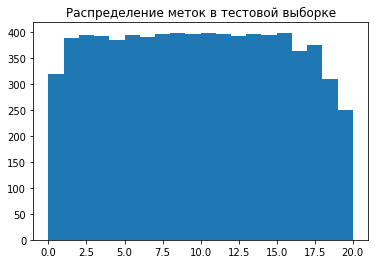

In [ ]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

## Train Simple Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

In [ ]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.49547889185785
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.6539022582336975
Доля верных ответов 0.8190387679235263


## Обучение модели на PyTorch

In [ ]:
class SparseFeaturesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        cur_features = torch.from_numpy(self.features[idx].toarray()[0]).float()
        cur_label = torch.from_numpy(np.asarray(self.targets[idx])).long()
        return cur_features, cur_label

In [ ]:
def evaluate(model, dataset, max_ex=0):
    acc = 0
    N = len(dataset) * batch_size
    for i, (features, labels) in enumerate(dataset):
        features = features.to(device)
        labels = labels.to(device)
        scores = model(features)
        pred = torch.argmax(scores, dim=1)
        acc += torch.sum(torch.eq(pred, labels)).item()
        if max_ex != 0 and i >= max_ex:
            break
    # print(i)
    return (acc * 100 / ((i+1) * batch_size) )

### Teacher Network

In [ ]:
class DNN(nn.Module):
    def __init__(self, input_size, output_size, dropout=0.5):
        super(DNN, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.linear_1 = nn.Linear(input_size, 1200)
        self.linear_2 = nn.Linear(1200, 1200)
        self.linear_3 = nn.Linear(1200, 600)
        self.linear_4 = nn.Linear(600, output_size)

    def forward(self, input):
        scores = self.linear_1(input)
        scores = self.relu(scores)
        scores = self.linear_2(scores)
        scores = self.relu(scores)
        scores = self.linear_3(scores)
        scores = self.relu(scores)
        scores = self.dropout(scores)
        scores = self.linear_4(scores)
        return scores

In [ ]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
val_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

In [ ]:
lr=5e-3
epochs=20
batch_size=1000

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = DNN(UNIQUE_WORDS_N, UNIQUE_LABELS_N).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
train_loss = []
train_acc = []
val_acc = []
it = 0
for epoch in range(epochs):
    mean_train_loss = 0
    train_batches_n = 0
    epoch_start = datetime.datetime.now()
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device)
        
        scores = model(X)
        loss = criterion(scores, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_train_loss += float(loss)
        train_batches_n += 1
        train_loss.append(loss.item())
        
        if it % 100 == 0:
            train_acc.append(evaluate(model, train_dataloader, max_ex=100))
            val_acc.append(evaluate(model, val_dataloader))
            # plot_loss(train_loss, it, it_per_epoch, base_name=output_dir + "loss_"+title, title=title)
            # plot_acc(train_acc, val_acc, it, it_per_epoch, base_name=output_dir + "acc_"+title, title=title)
        it += 1

    mean_train_loss /= train_batches_n
    print('Epoch: {}, {:0.2f} sec'.format(epoch,(datetime.datetime.now() - epoch_start).total_seconds()))
    print('Mean train loss', mean_train_loss)
    print()

Epoch: 0, 6.86 sec
Mean train loss 2.9868215123812356

Epoch: 1, 2.57 sec
Mean train loss 2.526939789454142

Epoch: 2, 2.58 sec
Mean train loss 1.6921601593494415

Epoch: 3, 2.54 sec
Mean train loss 1.0785684287548065

Epoch: 4, 2.75 sec
Mean train loss 0.5881364817420641

Epoch: 5, 2.58 sec
Mean train loss 0.25086018443107605

Epoch: 6, 2.59 sec
Mean train loss 0.1071532132724921

Epoch: 7, 2.56 sec
Mean train loss 0.05398307057718436

Epoch: 8, 6.76 sec
Mean train loss 0.03571020967016617

Epoch: 9, 2.56 sec
Mean train loss 0.024697011181463797

Epoch: 10, 2.59 sec
Mean train loss 0.020301290632536013

Epoch: 11, 2.58 sec
Mean train loss 0.01797020675924917

Epoch: 12, 2.54 sec
Mean train loss 0.014106585062108934

Epoch: 13, 2.76 sec
Mean train loss 0.010898301746541014

Epoch: 14, 2.56 sec
Mean train loss 0.006617743230890483

Epoch: 15, 2.55 sec
Mean train loss 0.010579523863270879

Epoch: 16, 6.60 sec
Mean train loss 0.007107668789103627

Epoch: 17, 2.76 sec
Mean train loss 0.010

In [ ]:
train_acc.append(evaluate(model, train_dataloader, max_ex=100))
val_acc.append(evaluate(model, val_dataloader))

train_acc = evaluate(model, train_dataloader)
print("\nTrain accuracy: %.2f%%" % train_acc)
val_acc = evaluate(model,val_dataloader)
print("Validation accuracy: %.2f%%" % val_acc)


Train accuracy: 94.20%
Validation accuracy: 49.77%


### Student Network

In [ ]:
class small_DNN(nn.Module):
    def __init__(self, vocab_size, num_labels):
        super(small_DNN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(vocab_size, 50),
            nn.ReLU(),
            nn.Linear(50, num_labels)
        )

In [ ]:
softmax_op = nn.Softmax(dim=1)
mseloss_fn = nn.MSELoss()

def loss_func(scores, targets, temperature = 5):
    soft_pred = softmax_op(scores / temperature)
    soft_targets = softmax_op(targets / temperature)
    loss = mseloss_fn(soft_pred, soft_targets)
    return loss

In [ ]:
def distill_train_eval_loop(small_model, big_model, temp, train_dataset, val_dataset,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, 
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):



    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break
                
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                
                preds = small_model(batch_x)
                targets = big_model(batch_y)
                loss = my_loss(preds, targets, temperature = temp)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)

            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break
                    batch_x = batch_x.to(device)
                    batch_y = batch_y.to(device)
                    
                    preds = small_model(batch_x)
                    targets = big_model(batch_y)
                    loss = my_loss(preds, targets, temperature = temp)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model

In [ ]:
big_model = DNN(UNIQUE_WORDS_N, UNIQUE_LABELS_N).to(device)
small_model = small_DNN(UNIQUE_WORDS_N, UNIQUE_LABELS_N).to(device)
temp = 4

best_val_loss, best_model = distill_train_eval_loop(small_model, big_model, temp,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            lr=1e-4,
                                            epoch_n=20,
                                            batch_size=32)

In [ ]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))